In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=07f4510b0341c500c97df6f1d08b5642340433401441b8dbc3eb59fe24c0c46f
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [8]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.inspection import PartialDependenceDisplay
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [4]:
X_train_final = pd.read_csv('/content/X_train_final.csv')
X_test_final = pd.read_csv('/content/X_test_final.csv')
y_train = pd.read_csv('/content/y_train_final.csv').squeeze()
y_test = pd.read_csv('/content/y_test_final.csv').squeeze()

In [10]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(f"AUC: {roc_auc_score(y_test, y_pred):.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## CatBoost Classifier Model


CatBoost Evaluation
Accuracy: 0.94
Precision: 0.93
Recall: 0.96
F1 Score: 0.95
AUC: 0.94
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       544
           1       0.93      0.96      0.95       635

    accuracy                           0.94      1179
   macro avg       0.95      0.94      0.94      1179
weighted avg       0.94      0.94      0.94      1179



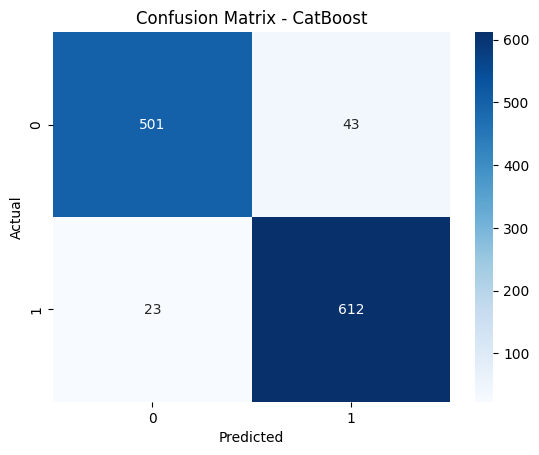

In [11]:
cat_final = CatBoostClassifier(verbose=False, random_state=42)
cat_final.fit(X_train_final, y_train)
evaluate_model("CatBoost", cat_final, X_test_final, y_test)

### SHAP for CatBoost

In [12]:
sample_instance = X_test_final.iloc[0]

explainer = LimeTabularExplainer(
    X_train_final.values,
    feature_names=X_train_final.columns.tolist(),
    class_names=['No Churn', 'Churn'],
    discretize_continuous=True
)


SHAP Summary for CatBoost


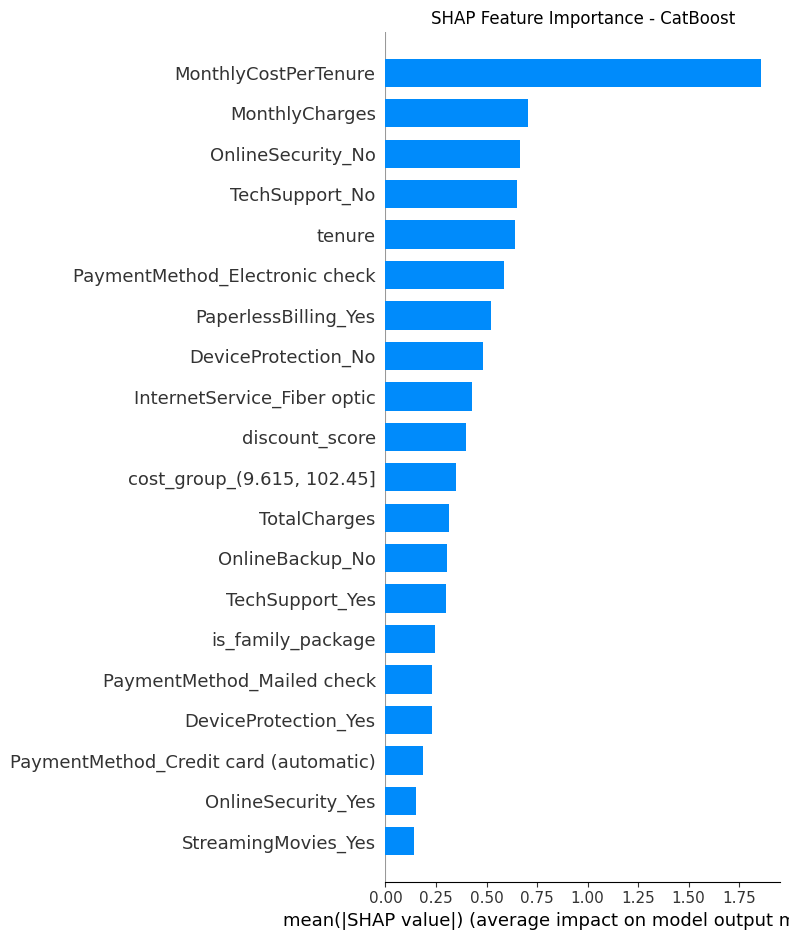

In [13]:
print("\nSHAP Summary for CatBoost")
explainer_cat = shap.TreeExplainer(cat_final)
shap_values_cat = explainer_cat.shap_values(X_test_final)
shap.summary_plot(shap_values_cat, X_test_final, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - CatBoost")
plt.tight_layout()
plt.show()

This SHAP bar plot shows the global feature importance in predicting customer churn:

* MonthlyCostPerTenure is by far the most influential feature, indicating that customers paying a high amount per tenure period are significantly more likely to churn.

* MonthlyCharges and OnlineSecurity_No follow, suggesting that high charges and lack of security services are strong churn drivers.

* Features like TechSupport_No, tenure, and PaymentMethod_Electronic check also contribute substantially—shorter tenure and electronic check payments are often associated with churn.

* Lower-ranked features, such as StreamingMovies_Yes and OnlineSecurity_Yes, have a weaker overall influence on model decisions.

The CatBoost model relies most heavily on billing-related features and service unavailability (like missing security or tech support) to predict churn.

### LIME for CatBoost

In [14]:
print("\nLIME Explanation for CatBoost")
exp = explainer.explain_instance(sample_instance.values, cat_final.predict_proba)
exp.show_in_notebook()


LIME Explanation for CatBoost


This LIME explanation provides a local interpretation for a single customer prediction:

* The model predicts a 74% probability of churn.

* The most influential feature pushing the prediction toward churn is high MonthlyCostPerTenure (43.80), contributing 0.44 to the decision.

* Additional churn indicators include:

    * Lack of OnlineSecurity, TechSupport, and DeviceProtection

    * Use of Electronic check as a payment method

In contrast, features like TechSupport_Yes, PaperlessBilling_Yes, and use of credit card or mailed check for payment slightly counter the churn prediction.

For this specific customer, high payment relative to tenure, combined with the absence of support/security services and risky payment method, significantly raised the model’s confidence in predicting churn.

### PDP for CatBoost

In [15]:
selected_feature = 'MonthlyCostPerTenure'
feature_index = X_train_final.columns.tolist().index(selected_feature)


PDP - CatBoost


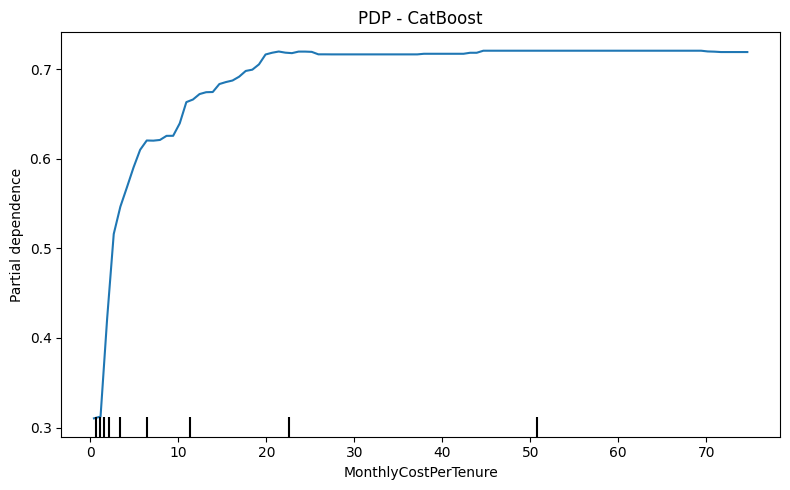

In [16]:
print("\nPDP - CatBoost")
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(cat_final, X_test_final, [feature_index], ax=ax)
ax.set_title("PDP - CatBoost")
plt.tight_layout()
plt.show()

This Partial Dependence Plot shows how the feature MonthlyCostPerTenure affects the model’s prediction of churn:

  * The partial dependence rises steeply as MonthlyCostPerTenure increases, particularly in the 0 to 10 range.

  * Beyond a value of ~25, the curve plateaus, indicating that further increases in this feature do not significantly raise the predicted churn probability.

Customers who pay more per month relative to how long they've stayed are much more likely to churn. The risk stabilizes once the value reaches a high threshold, suggesting a saturation point in the model’s sensitivity to this feature.

### ICE for CatBoost

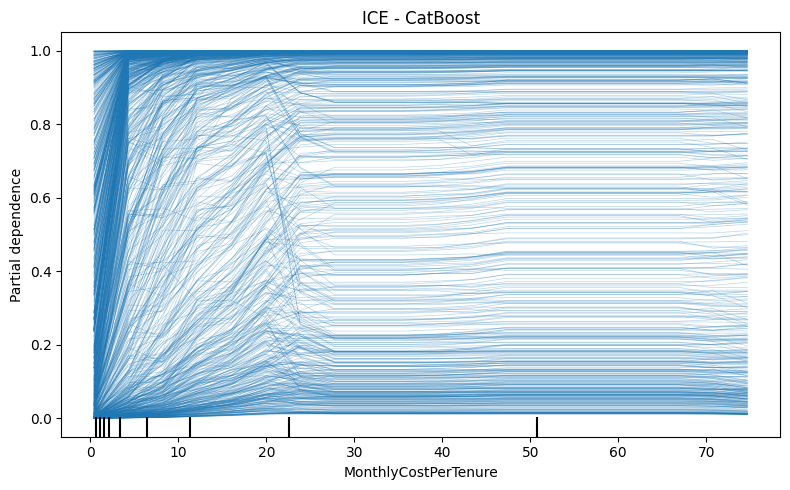

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(cat_final, X_test_final, [feature_index], kind='individual', grid_resolution=20, ax=ax)
ax.set_title("ICE - CatBoost")
plt.tight_layout()
plt.show()

This ICE illustrates how the feature MonthlyCostPerTenure influences churn predictions at the individual customer level:

* Each line represents a single customer and how their predicted churn probability would change if only MonthlyCostPerTenure varied, while all other features remained fixed.

* The plot shows a consistent upward trend for many customers when MonthlyCostPerTenure increases from 0 to ~20, meaning their churn probability increases with cost.

* Beyond ~25, many lines flatten, indicating that higher values do not further affect the churn prediction for most customers.

* A few customers show non-linear or unexpected behavior, but the majority follow a similar increasing trend.

Higher MonthlyCostPerTenure strongly increases churn likelihood for many customers, especially in the low-to-mid range, reinforcing the PDP’s conclusion. ICE plots add value by revealing how individual responses differ even when the global trend is clear.

## LightGBM Classifier Model

In [21]:
def clean_feature_names(df):
    df.columns = df.columns.str.replace(r"[\[\]\(\),<]", "_", regex=True)
    df.columns = df.columns.str.replace(r"\s+", "_", regex=True)
    return df

X_train_final = clean_feature_names(X_train_final)
X_test_final = clean_feature_names(X_test_final)

[LightGBM] [Info] Number of positive: 2536, number of negative: 2176
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1131
[LightGBM] [Info] Number of data points in the train set: 4712, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538200 -> initscore=0.153100
[LightGBM] [Info] Start training from score 0.153100

LightGBM Evaluation
Accuracy: 0.94
Precision: 0.94
Recall: 0.95
F1 Score: 0.94
AUC: 0.94
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       544
           1       0.94      0.95      0.94       635

    accuracy                           0.94      1179
   macro avg       0.94      0.94      0.94      1179
weighted avg       0.94      0.94      0.94      1179



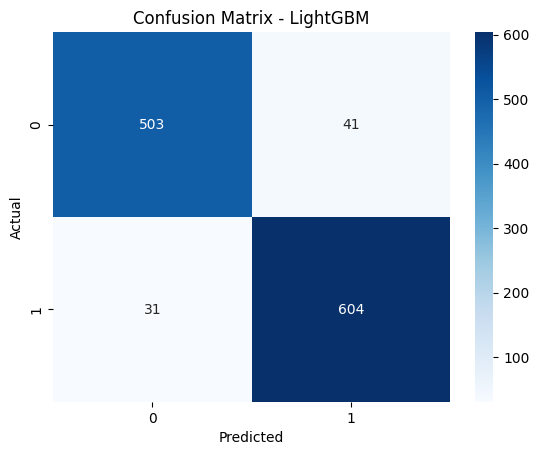

In [22]:
lgb_final = LGBMClassifier(random_state=42)
lgb_final.fit(X_train_final, y_train)
evaluate_model("LightGBM", lgb_final, X_test_final, y_test)

### SHAP for LightGBM


SHAP Summary for LightGBM


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


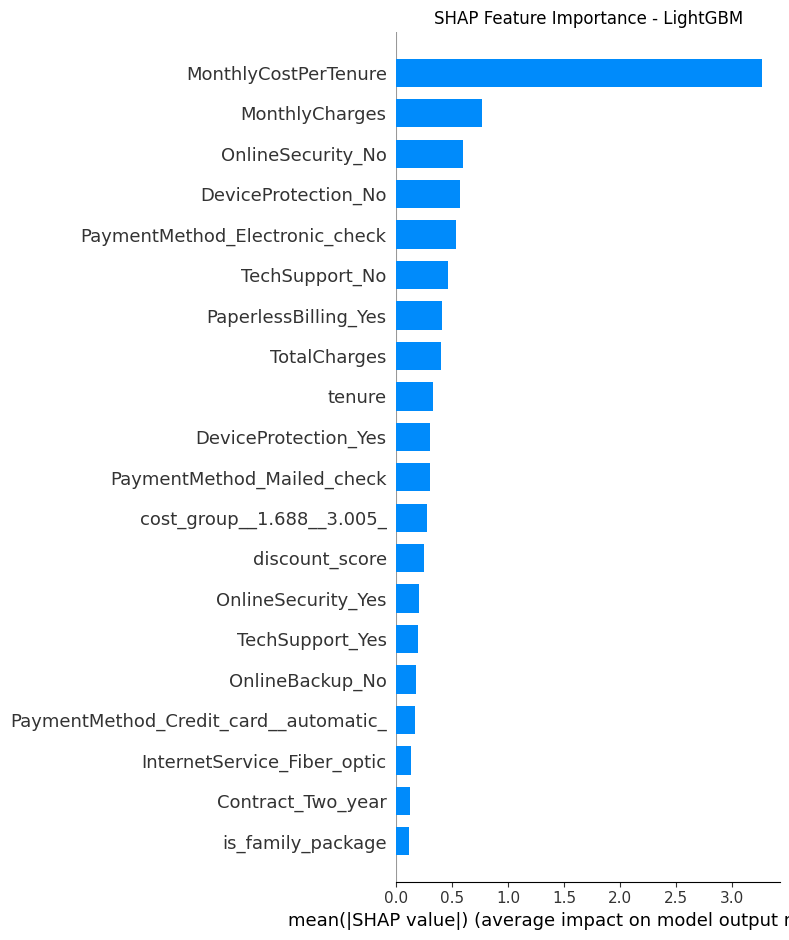

In [23]:
print("\nSHAP Summary for LightGBM")
explainer_lgb = shap.TreeExplainer(lgb_final)
shap_values_lgb = explainer_lgb.shap_values(X_test_final)
shap.summary_plot(shap_values_lgb, X_test_final, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - LightGBM")
plt.tight_layout()
plt.show()

This SHAP summary plot shows the average feature impact on churn predictions:

* MonthlyCostPerTenure is by far the most important feature, suggesting customers who pay more relative to their tenure are much more likely to churn.

* MonthlyCharges, OnlineSecurity_No, and DeviceProtection_No also have significant contributions, indicating billing and lack of security services increase churn risk.

* Other features like contract type, support availability, and payment method have smaller but noticeable impacts.

The LightGBM model heavily relies on billing behavior and service availability to predict churn, with MonthlyCostPerTenure being the most influential driver.

### LIME for LightGBM

In [24]:
print("\nLIME Explanation for LightGBM")
exp = explainer.explain_instance(sample_instance.values, lgb_final.predict_proba)
exp.show_in_notebook()


LIME Explanation for LightGBM


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


This LIME explanation shows a local explanation for a single customer prediction:

* The model predicts a high probability of churn (84%).

* Key drivers toward churn include:

* High MonthlyCostPerTenure (contributes the most with +0.48),

* No Tech Support, Device Protection, or Online Security,

* Use of Electronic check as a payment method.

This customer pays a lot compared to how long they've been subscribed and lacks protection/support services, all of which increase churn risk. LIME confirms the global SHAP insights at an individual level.









### PDP for LightGBM


PDP - LightGBM


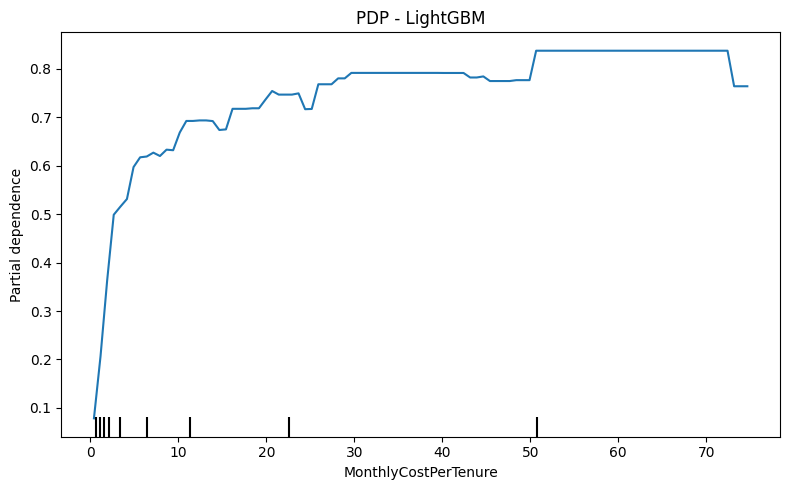

In [25]:
print("\nPDP - LightGBM")
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(lgb_final, X_test_final, [feature_index], ax=ax)
ax.set_title("PDP - LightGBM")
plt.tight_layout()
plt.show()

This PDP shows the relationship between MonthlyCostPerTenure and churn probability:

* Positive Correlation: As MonthlyCostPerTenure increases, the partial dependence (the predicted churn risk) rises rapidly.

* Plateau Behavior: Around a cost per tenure of ~30, the curve flattens, suggesting that beyond this point, increasing cost has little additional effect on churn risk.

Customers who are paying more relative to their tenure are significantly more likely to churn. This supports the idea that high early costs may cause dissatisfaction and early exits.

### ICE for LightGBM

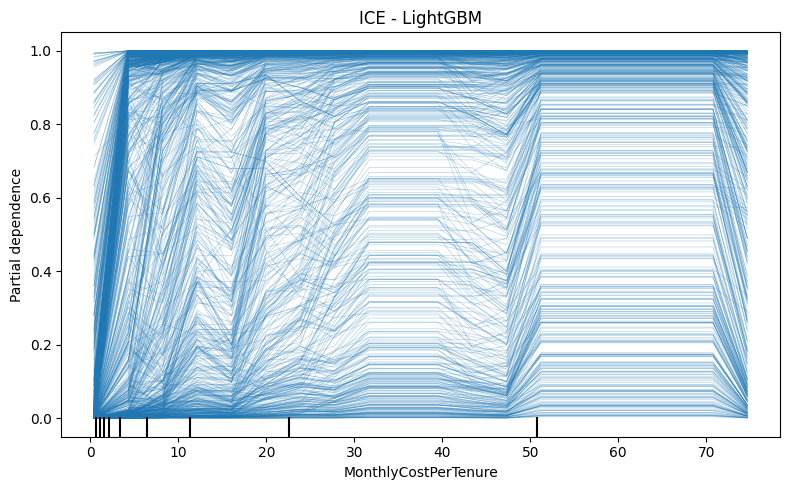

In [26]:
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(lgb_final, X_test_final, [feature_index], kind='individual', grid_resolution=20, ax=ax)
ax.set_title("ICE - LightGBM")
plt.tight_layout()
plt.show()

This ICE plot illustrates how the MonthlyCostPerTenure feature affects predicted churn probability at the individual level:

* Sharp early increase: For most instances, churn probability jumps sharply when cost per tenure is low—showing sensitivity to this feature early on.

* Horizontal lines: After a certain threshold (~30–50), most lines flatten, indicating saturation—higher cost per tenure no longer increases predicted churn significantly.

* Individual variation: The spread of lines at lower values shows that different customers respond differently, confirming model nonlinearity and heterogeneity in churn behavior.

High early costs are critical churn triggers, while later increases have diminishing effects.